<a href="https://colab.research.google.com/github/Maaslak/GSN-adversarial_attension/blob/develop/create_adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Common Imports and downlowding a datasets

Downlowding datasets:
* cats vs dogs


In [0]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image
from zipfile import ZipFile 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!rm -rf sample_data

In [44]:
!mkdir -p /root/.kaggle
!echo '{"username":"USERNAME","key":"API_KEY"}' > /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [46]:
!kaggle datasets download "chetankv/dogs-cats-images"

401 - Unauthorized


In [47]:
!unzip -q dogs-cats-images.zip

replace dataset/test_set/cats/cat.4001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Reading dogs vs cats ds 

In [0]:
test_dir="dog vs cat/dataset/test_set"
train_dir="dog vs cat/dataset/training_set"

train_dir_cats = train_dir + '/cats'
train_dir_dogs = train_dir + '/dogs'
test_dir_cats = test_dir + '/cats'
test_dir_dogs = test_dir + '/dogs'

In [0]:
import pathlib
DATA_DIR = "dog vs cat/dataset/"
train_dir = pathlib.Path(DATA_DIR + "training_set")
test_dir = pathlib.Path(DATA_DIR + "test_set")

In [50]:
train_image_count = len(list(train_dir.glob('*/*.jpg')))
test_image_count = len(list(test_dir.glob('*/*.jpg')))
(train_image_count, test_image_count)

(8000, 2000)

In [51]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['cats', 'dogs'], dtype='<U4')

In [0]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 128

In [0]:
data_generator = ImageDataGenerator(rescale = 1.0/255.0, zoom_range = 0.2)

In [0]:
def list_files(data_dir):
  return tf.data.Dataset.list_files(str(data_dir/'*/*'))

In [0]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [0]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])


In [0]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [58]:
AUTOTUNE = 100

def load_cats_vs_dogs():
  train_list_ds = list_files(train_dir)
  test_list_ds = list_files(test_dir)

  for f in train_list_ds.take(5):
    print(f.numpy())
  # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
  return (
      train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE),
      test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE),
  )

train_labeled_ds, test_labeled_ds = load_cats_vs_dogs()

b'dog vs cat/dataset/training_set/dogs/dog.1035.jpg'
b'dog vs cat/dataset/training_set/cats/cat.1985.jpg'
b'dog vs cat/dataset/training_set/cats/cat.364.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.254.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.1961.jpg'


In [59]:
for image, label in train_labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


Image shape:  (224, 224, 3)
Label:  [ True False]


In [0]:
def prepare_for_training(ds, batch_size=BATCH_SIZE, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(batch_size)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds

In [0]:
train_ds = prepare_for_training(train_labeled_ds)

image_batch, label_batch = next(iter(train_ds))

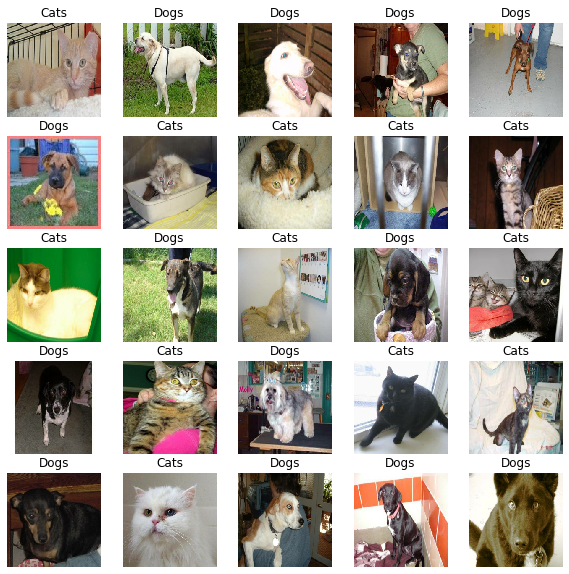

In [62]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

show_batch(image_batch.numpy(), label_batch.numpy())

## TF for local runs


In [0]:
def allow_memory_growth():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
# run the line below if you're using local runtime and have GTX > 1660 (this is known bug with tensorflow memory allocation)
# allow_memory_growth()

## Model definition

In [0]:
import tensorflow.keras.layers as layers
from tensorflow.keras import Sequential
from tensorflow.keras.applications import ResNet101

In [0]:
class AttensionALPModel(tf.keras.Model):

  def __init__(self, num_classes, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)):
    super(AttensionALPModel, self).__init__(name="attension_alp_model")
    self.num_classes = num_classes
    self.res_net_101 = ResNet101(input_shape=input_shape)
    self.classifier = Sequential()
    self.classifier.add(layers.Flatten())
    self.classifier.add(layers.Dense(1024, activation="relu"))
    self.classifier.add(layers.Dropout(0.4))
    self.classifier.add(layers.Dense(200, activation='relu'))
    self.classifier.add(layers.Dropout(0.5))
    self.classifier.add(layers.Dense(num_classes, activation='softmax'))

  def call(self, inputs):
    resnet_features = self.res_net_101(inputs)
    return self.classifier(resnet_features)

def train_step_attension_alp_model(attension_alp_model, optim, loss_f):
  @tf.function
  def _train_step_attension_alp_model(images, labels):
    with tf.GradientTape() as tape:
      out = attension_alp_model(images, True)      
      loss = loss_f(real_out, gen_out)
    
    grads = tape.gradient(loss, attension_alp_model.classifier.trainable_variables)
    optim.apply_gradients(zip(grads, attension_alp_model.classifier.trainable_variables))
  
  return _train_step_attension_alp_model


In [0]:
def train(train_step, train_data, ds_f, epochs, batch_size=BATCH_SIZE):
  train_ds = ds_f(train_data, batch_size)

  for epoch in range(epochs):
    
    for images, labels in train_ds:
      train_step(images, labels)
    
    print('Epoch {0}/{1}'.format(epoch, epochs))


## Train Model

In [0]:
attension_alp_model = AttensionALPModel(2)
optim = tf.optimizers.Nadam(1e-4)

train_step = train_step_attension_alp_model(
    attension_alp_model=attension_alp_model,
    optim=optim,
    loss_f=tf.keras.losses.SparseCategoricalCrossentropy() )

In [70]:
train_data, test_data = load_cats_vs_dogs()

train(
    train_step=train_step,
    train_data=train_data,
    ds_f=prepare_for_training,
    epochs=1,
    batch_size=BATCH_SIZE
    )

b'dog vs cat/dataset/training_set/dogs/dog.2502.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.2450.jpg'
b'dog vs cat/dataset/training_set/dogs/dog.1599.jpg'
b'dog vs cat/dataset/training_set/cats/cat.1717.jpg'
b'dog vs cat/dataset/training_set/cats/cat.158.jpg'


TypeError: ignored

## FGSM model

In [0]:
class AdversarialPaternFinder(object):
  def __init__(self, model):
    self.model = model

  def create_adversarial_pattern(self, input_image, input_label, **kwargs):
    raise NotImplementedError

  def apply_adversarial_pattern(self, pattern, input_image, **kwargs):
    raise NotImplementedError

  def generate_adversarial_example(self, input_image, input_label, 
                                   create_args, apply_args):
    pattern = self._create_adversarial_pattern(input_image, input_label, 
                                               **create_args)
    return self._apply_adversarial_pattern(pattern, input_image, **apply_args)

class FGSM(AdversarialPaternFinder):
  def create_adversarial_pattern(self, input_image, input_label, **kwargs):
    with tf.GradientTape() as tape:
      tape.watch(input_image)
      prediction = self.model(input_image)
      loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

  def apply_adversarial_pattern(self, pattern, input_image, **kwargs):
    epsilon = kwargs.getdefault("epsilon", 0.01)
    return input_image + epsilon * pattern

